# NNDL miniProj1 
fatemeh haghighi

810195385

sajjad pakdaman

810195517

## setup


### import

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [0]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import cv2
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D , MaxPooling2D
from keras.layers.normalization import BatchNormalization

from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras.preprocessing.image import  ImageDataGenerator as IDG


np.random.seed(1234)

### download dataset from [here](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html)

In [0]:
!wget "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip"
!unzip -qq GTSRB-Training_fixed.zip
!wget "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip"
!unzip -qq GTSRB_Final_Test_GT.zip
!wget "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip"
!unzip -qq GTSRB_Final_Test_Images.zip

## data loader

In [0]:
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

def TSreadTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Final_Tets/images/'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    with open('/content/GT-final_test.csv') as gtFile:# annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(rootpath + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
    return images, labels


In [0]:
tr_images , tr_labels = readTrafficSigns('./GTSRB/Training')
ts_images , ts_labels = TSreadTrafficSigns('./GTSRB/Final_Test/Images/')

# make all the images have size(30, 30)
for i , img in enumerate(tr_images):
    tr_images[i] = cv2.resize(img , (30,30))

for i, img in enumerate(ts_images):
    ts_images[i] = cv2.resize(img, (30,30))

## basic data analysis

### class bias

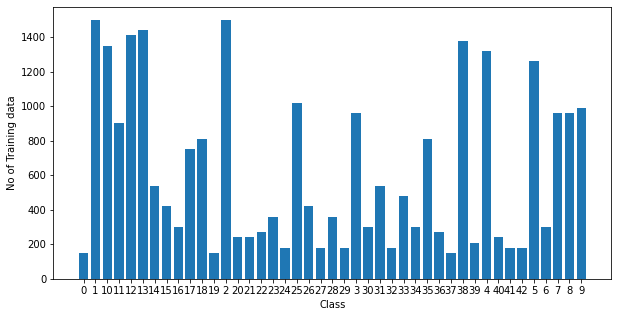

In [0]:
unique_elements, counts_elements = np.unique(sorted(tr_labels), return_counts = True)
plt.figure(figsize=(10 , 5))
plt.bar(unique_elements , counts_elements)
plt.xlabel('Class')
plt.ylabel('No of Training data')

mx_count = max(counts_elements)

some random picks of data set

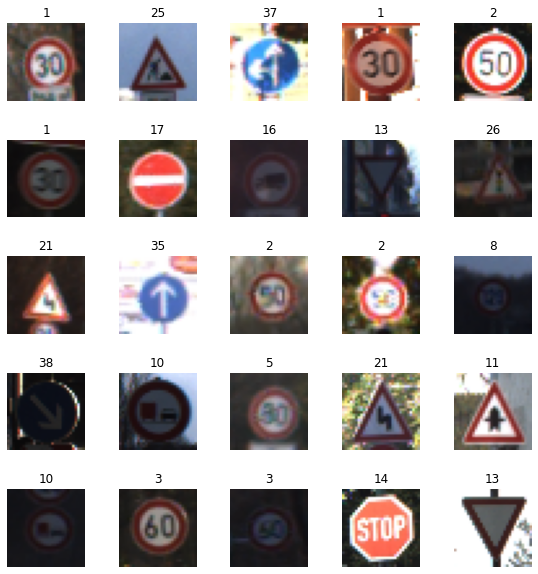

In [0]:
fig, axs = plt.subplots(5,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(25):
    index = random.randint(0, len(tr_images))
    image = tr_images[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(tr_labels[index])

In [0]:
# standard data
tr_images = np.array(tr_images,dtype=np.float32)/255.0
ts_images = np.array(ts_images,dtype=np.float32)/255.0
tr_labels = keras.utils.to_categorical(tr_labels)
ts_labels = keras.utils.to_categorical(ts_labels)

## A) CNN model

In [0]:
n_classes = 43
def create_model(activation_function):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),activation= activation_function , input_shape=(30, 30, 3))) # 28x28x32
  model.add(MaxPooling2D(pool_size=(2, 2))) # 14x14x32

  model.add(Conv2D(64, kernel_size=(3, 3), activation=activation_function)) # 12x12x64
  model.add(MaxPooling2D(pool_size=(2, 2))) # 6x6x64

  model.add(Conv2D(128, kernel_size=(3, 3), activation=activation_function)) #4x4x128
  model.add(MaxPooling2D(pool_size=(2, 2))) #2x2x128
  model.add(Flatten())

  model.add(Dense(128, activation=activation_function))
  model.add(Dense(n_classes, activation='softmax'))
  return model

In [0]:
modela = create_model('relu')
modela.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
historya = modela.fit(tr_images, tr_labels, validation_data=(ts_images, ts_labels), batch_size=128, epochs = 25)
# historya = modela.fit(tr_images, tr_labels, validation_split = 0.4, batch_size=128, epochs = 25)


Train on 26640 samples, validate on 12630 samples
Epoch 1/25
26640/26640 [==============================] - 2s 62us/step - loss: 2.1668 - accuracy: 0.4284 - val_loss: 1.1944 - val_accuracy: 0.6494
Epoch 2/25
26640/26640 [==============================] - 1s 56us/step - loss: 0.5543 - accuracy: 0.8437 - val_loss: 0.8509 - val_accuracy: 0.8118
Epoch 3/25
26640/26640 [==============================] - 2s 57us/step - loss: 0.2488 - accuracy: 0.9347 - val_loss: 0.6890 - val_accuracy: 0.8531
Epoch 4/25
26640/26640 [==============================] - 1s 56us/step - loss: 0.1491 - accuracy: 0.9613 - val_loss: 0.7437 - val_accuracy: 0.8567
Epoch 5/25
26640/26640 [==============================] - 1s 56us/step - loss: 0.0969 - accuracy: 0.9755 - val_loss: 0.6466 - val_accuracy: 0.8701
Epoch 6/25
26640/26640 [==============================] - 1s 56us/step - loss: 0.0690 - accuracy: 0.9836 - val_loss: 0.6814 - val_accuracy: 0.8811
Epoch 7/25
26640/26640 [==============================] - 2s 56us/st

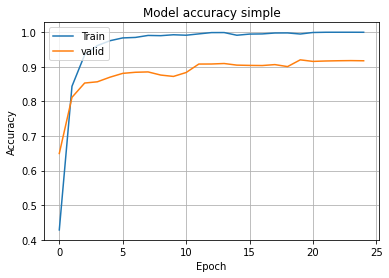

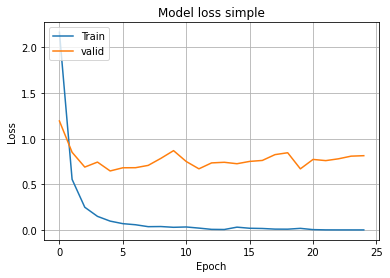

In [0]:
plt.plot(historya.history['accuracy'])
plt.plot(historya.history['val_accuracy'])
plt.title('Model accuracy simple')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'valid'], loc='upper left')
plt.grid()
plt.show()

# Plot training & validation loss values
plt.plot(historya.history['loss'])
plt.plot(historya.history['val_loss'])
plt.title('Model loss simple')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'valid'], loc='upper left')
plt.grid()
plt.show()

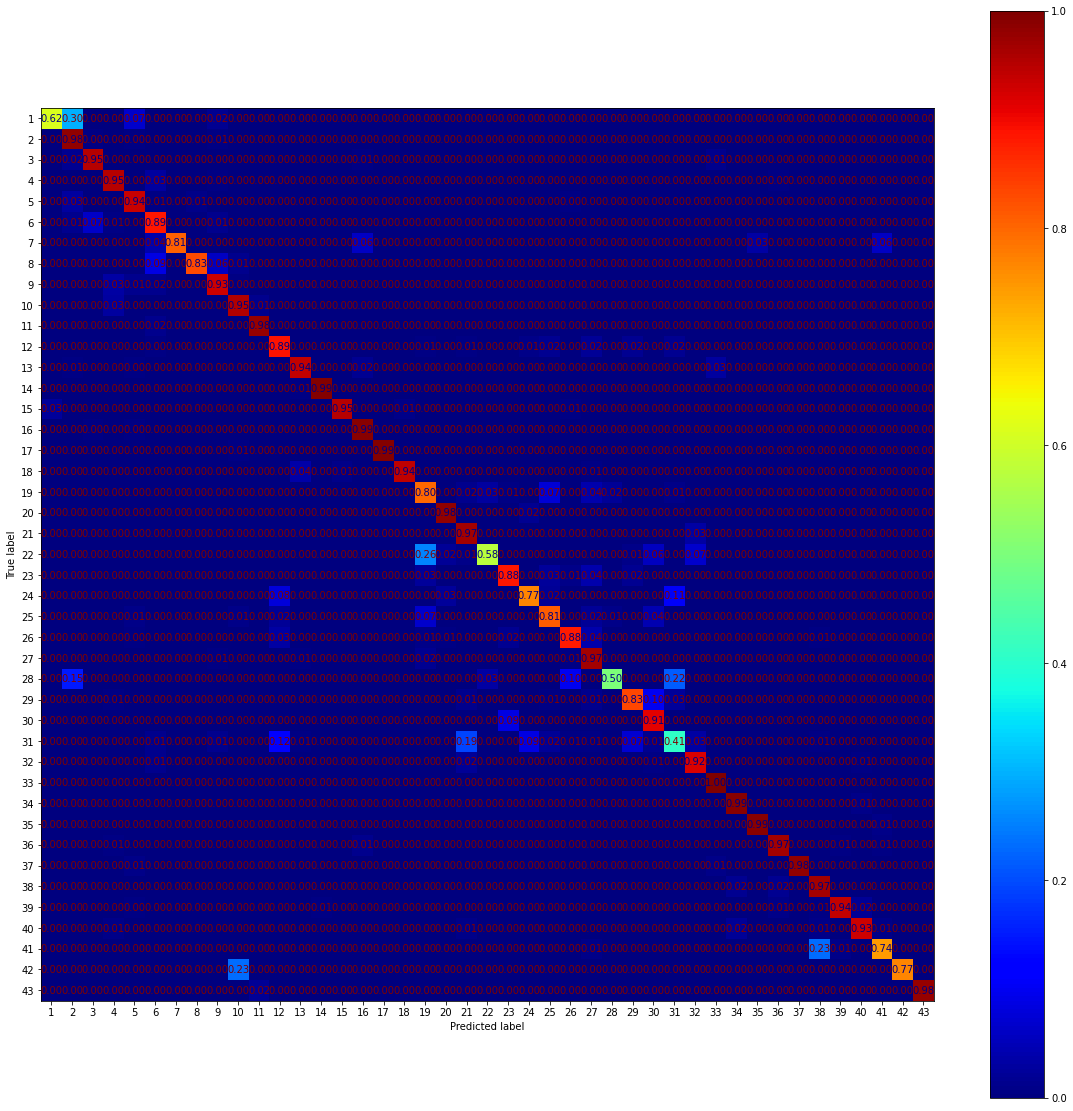

In [0]:
ts_labels_pred = modela.predict_classes(ts_images)
fig , ax = plt.subplots(figsize=(20, 20))
CMD(confusion_matrix(np.argmax(ts_labels, axis=1), ts_labels_pred, normalize='true') , [i+1 for i in range(n_classes)]).plot(ax=ax, values_format = '.2f', cmap='jet')

## Use different activation function

In [0]:
model_relu = create_model('relu')
model_tanh = create_model('tanh')
model_sigmoid = create_model('sigmoid')

In [0]:
model_relu.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_tanh.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_sigmoid.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [0]:
train_model_relu = model_relu.fit(tr_images, tr_labels, validation_data=(ts_images, ts_labels), batch_size=128, epochs = 15)


Train on 26640 samples, validate on 12630 samples
Epoch 1/15
26640/26640 [==============================] - 2s 60us/step - loss: 2.3208 - accuracy: 0.3640 - val_loss: 1.4012 - val_accuracy: 0.5645
Epoch 2/15
26640/26640 [==============================] - 1s 55us/step - loss: 0.6848 - accuracy: 0.7997 - val_loss: 0.7667 - val_accuracy: 0.7879
Epoch 3/15
26640/26640 [==============================] - 1s 54us/step - loss: 0.2712 - accuracy: 0.9283 - val_loss: 0.5475 - val_accuracy: 0.8626
Epoch 4/15
26640/26640 [==============================] - 1s 54us/step - loss: 0.1513 - accuracy: 0.9618 - val_loss: 0.5245 - val_accuracy: 0.8835
Epoch 5/15
26640/26640 [==============================] - 1s 54us/step - loss: 0.0902 - accuracy: 0.9787 - val_loss: 0.5619 - val_accuracy: 0.8952
Epoch 6/15
26640/26640 [==============================] - 1s 54us/step - loss: 0.0690 - accuracy: 0.9823 - val_loss: 0.5956 - val_accuracy: 0.8892
Epoch 7/15
26640/26640 [==============================] - 1s 54us/st

In [0]:
    train_model_tanh = model_tanh.fit(tr_images, tr_labels, validation_data=(ts_images, ts_labels), batch_size=128, epochs = 15)


Train on 26640 samples, validate on 12630 samples
Epoch 1/15
26640/26640 [==============================] - 2s 61us/step - loss: 1.5784 - accuracy: 0.5908 - val_loss: 0.6504 - val_accuracy: 0.8371
Epoch 2/15
26640/26640 [==============================] - 1s 54us/step - loss: 0.2268 - accuracy: 0.9561 - val_loss: 0.3770 - val_accuracy: 0.9051
Epoch 3/15
26640/26640 [==============================] - 1s 54us/step - loss: 0.0831 - accuracy: 0.9870 - val_loss: 0.3070 - val_accuracy: 0.9162
Epoch 4/15
26640/26640 [==============================] - 1s 54us/step - loss: 0.0432 - accuracy: 0.9939 - val_loss: 0.2723 - val_accuracy: 0.9274
Epoch 5/15
26640/26640 [==============================] - 1s 55us/step - loss: 0.0226 - accuracy: 0.9980 - val_loss: 0.2682 - val_accuracy: 0.9292
Epoch 6/15
26640/26640 [==============================] - 1s 54us/step - loss: 0.0137 - accuracy: 0.9992 - val_loss: 0.2622 - val_accuracy: 0.9298
Epoch 7/15
26640/26640 [==============================] - 1s 53us/st

In [0]:
train_model_sigmoid = model_sigmoid.fit(tr_images, tr_labels, validation_data=(ts_images, ts_labels), batch_size=128, epochs = 15)


Train on 26640 samples, validate on 12630 samples
Epoch 1/15
26640/26640 [==============================] - 2s 61us/step - loss: 3.5013 - accuracy: 0.0598 - val_loss: 3.4216 - val_accuracy: 0.1001
Epoch 2/15
26640/26640 [==============================] - 1s 55us/step - loss: 3.3040 - accuracy: 0.1116 - val_loss: 3.2613 - val_accuracy: 0.1360
Epoch 3/15
26640/26640 [==============================] - 1s 56us/step - loss: 2.8509 - accuracy: 0.2283 - val_loss: 2.6175 - val_accuracy: 0.2836
Epoch 4/15
26640/26640 [==============================] - 1s 54us/step - loss: 2.0066 - accuracy: 0.4477 - val_loss: 1.8312 - val_accuracy: 0.4541
Epoch 5/15
26640/26640 [==============================] - 1s 55us/step - loss: 1.3695 - accuracy: 0.6099 - val_loss: 1.4286 - val_accuracy: 0.5587
Epoch 6/15
26640/26640 [==============================] - 1s 55us/step - loss: 0.9913 - accuracy: 0.7264 - val_loss: 1.1376 - val_accuracy: 0.6702
Epoch 7/15
26640/26640 [==============================] - 1s 55us/st

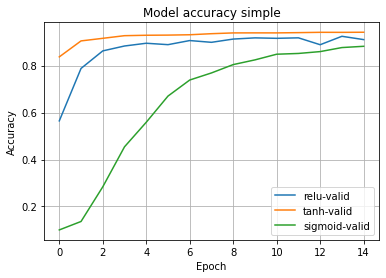

In [0]:
plt.plot(train_model_relu.history['val_accuracy'])
plt.plot(train_model_tanh.history['val_accuracy'])
plt.plot(train_model_sigmoid.history['val_accuracy'])

plt.title('Model accuracy simple')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['relu-valid', 'tanh-valid', 'sigmoid-valid'], loc='lower right')
plt.grid()
plt.show()


## Use different optimation 

In [0]:
model_1 = create_model('relu')
model_2 = create_model('relu')


In [0]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr = 0.09), metrics=['accuracy'])


In [0]:
train_model_1 = model_1.fit(tr_images, tr_labels, validation_data=(ts_images, ts_labels), batch_size=128, epochs = 15)

Train on 26640 samples, validate on 12630 samples
Epoch 1/15
26640/26640 [==============================] - 2s 61us/step - loss: 2.1698 - accuracy: 0.4202 - val_loss: 1.2515 - val_accuracy: 0.6345
Epoch 2/15
26640/26640 [==============================] - 1s 56us/step - loss: 0.5195 - accuracy: 0.8537 - val_loss: 0.8530 - val_accuracy: 0.7926
Epoch 3/15
26640/26640 [==============================] - 1s 56us/step - loss: 0.2166 - accuracy: 0.9429 - val_loss: 0.7900 - val_accuracy: 0.8443
Epoch 4/15
26640/26640 [==============================] - 2s 57us/step - loss: 0.1262 - accuracy: 0.9673 - val_loss: 0.7572 - val_accuracy: 0.8576
Epoch 5/15
26640/26640 [==============================] - 1s 55us/step - loss: 0.0811 - accuracy: 0.9800 - val_loss: 0.7006 - val_accuracy: 0.8654
Epoch 6/15
26640/26640 [==============================] - 1s 55us/step - loss: 0.0618 - accuracy: 0.9839 - val_loss: 0.7456 - val_accuracy: 0.8769
Epoch 7/15
26640/26640 [==============================] - 1s 56us/st

In [0]:
train_model_2 = model_2.fit(tr_images, tr_labels, validation_data=(ts_images, ts_labels), batch_size=128, epochs = 15)


Train on 26640 samples, validate on 12630 samples
Epoch 1/15
26640/26640 [==============================] - 1s 56us/step - loss: 3.4070 - accuracy: 0.1080 - val_loss: 3.5024 - val_accuracy: 0.1473
Epoch 2/15
26640/26640 [==============================] - 1s 51us/step - loss: 1.9394 - accuracy: 0.4723 - val_loss: 2.9436 - val_accuracy: 0.3698
Epoch 3/15
26640/26640 [==============================] - 1s 50us/step - loss: 0.7719 - accuracy: 0.7782 - val_loss: 2.5029 - val_accuracy: 0.5375
Epoch 4/15
26640/26640 [==============================] - 1s 51us/step - loss: 0.4038 - accuracy: 0.8846 - val_loss: 3.7554 - val_accuracy: 0.5285
Epoch 5/15
26640/26640 [==============================] - 1s 51us/step - loss: 0.3141 - accuracy: 0.9138 - val_loss: 0.8292 - val_accuracy: 0.8190
Epoch 6/15
26640/26640 [==============================] - 1s 51us/step - loss: 0.1520 - accuracy: 0.9566 - val_loss: 1.1562 - val_accuracy: 0.7662
Epoch 7/15
26640/26640 [==============================] - 1s 50us/st

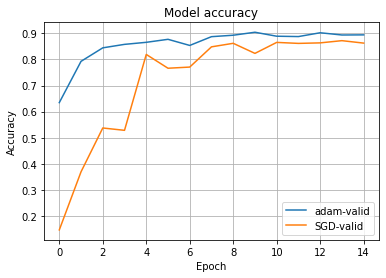

In [0]:
plt.plot(train_model_1.history['val_accuracy'])
plt.plot(train_model_2.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['adam-valid', 'SGD-valid'], loc='lower right')
plt.grid()
plt.show()


In [0]:
len(np.argmax(ts_labels , axis=1))

12630

## Use Droup out layer

In [0]:
def create_drop_out_model(n_classes = 43):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),activation= 'relu' , input_shape=(30, 30, 3))) # 28x28x32
  model.add(MaxPooling2D(pool_size=(2, 2))) # 14x14x32

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) # 12x12x64
  model.add(MaxPooling2D(pool_size=(2, 2))) # 6x6x64
  model.add(Dropout(0.5))


  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) #4x4x128
  model.add(MaxPooling2D(pool_size=(2, 2))) #2x2x128
  model.add(Dropout(0.5))
  model.add(Flatten())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))
  return model


In [0]:
model_dropless = create_model('relu')
model_dropOut = create_drop_out_model()

model_dropless.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dropOut.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [0]:
train_model_dropless = model_dropless.fit(tr_images, tr_labels, validation_data=(ts_images, ts_labels), batch_size=128, epochs = 100)


Train on 26640 samples, validate on 12630 samples
Epoch 1/100
26640/26640 [==============================] - 2s 60us/step - loss: 2.3411 - accuracy: 0.3661 - val_loss: 1.4200 - val_accuracy: 0.5818
Epoch 2/100
26640/26640 [==============================] - 1s 53us/step - loss: 0.6436 - accuracy: 0.8134 - val_loss: 0.9530 - val_accuracy: 0.7754
Epoch 3/100
26640/26640 [==============================] - 1s 53us/step - loss: 0.2766 - accuracy: 0.9233 - val_loss: 0.9556 - val_accuracy: 0.8074
Epoch 4/100
26640/26640 [==============================] - 1s 54us/step - loss: 0.1693 - accuracy: 0.9523 - val_loss: 0.8441 - val_accuracy: 0.8371
Epoch 5/100
26640/26640 [==============================] - 1s 53us/step - loss: 0.1047 - accuracy: 0.9710 - val_loss: 0.8929 - val_accuracy: 0.8432
Epoch 6/100
26640/26640 [==============================] - 1s 54us/step - loss: 0.0817 - accuracy: 0.9782 - val_loss: 0.9100 - val_accuracy: 0.8566
Epoch 7/100
26640/26640 [==============================] - 1s 

In [0]:
train_model_dropOut = model_dropOut.fit(tr_images, tr_labels, validation_data=(ts_images, ts_labels), batch_size=128, epochs = 100)


Train on 26640 samples, validate on 12630 samples
Epoch 1/100
26640/26640 [==============================] - 2s 66us/step - loss: 3.0642 - accuracy: 0.1740 - val_loss: 2.2071 - val_accuracy: 0.3599
Epoch 2/100
26640/26640 [==============================] - 2s 58us/step - loss: 1.9105 - accuracy: 0.4087 - val_loss: 1.3805 - val_accuracy: 0.5872
Epoch 3/100
26640/26640 [==============================] - 2s 58us/step - loss: 1.2772 - accuracy: 0.5892 - val_loss: 0.8370 - val_accuracy: 0.7500
Epoch 4/100
26640/26640 [==============================] - 2s 59us/step - loss: 0.8770 - accuracy: 0.7146 - val_loss: 0.5706 - val_accuracy: 0.8404
Epoch 5/100
26640/26640 [==============================] - 2s 58us/step - loss: 0.6658 - accuracy: 0.7848 - val_loss: 0.4381 - val_accuracy: 0.8873
Epoch 6/100
26640/26640 [==============================] - 2s 59us/step - loss: 0.5379 - accuracy: 0.8251 - val_loss: 0.3913 - val_accuracy: 0.8923
Epoch 7/100
26640/26640 [==============================] - 2s 

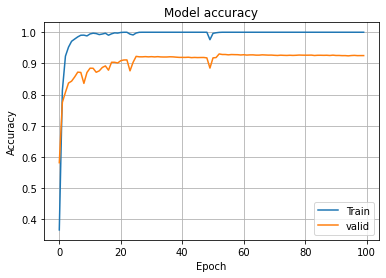

In [0]:
plt.plot(train_model_dropless.history['accuracy'])
plt.plot(train_model_dropless.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'valid'], loc='lower right')
plt.grid()
plt.show()

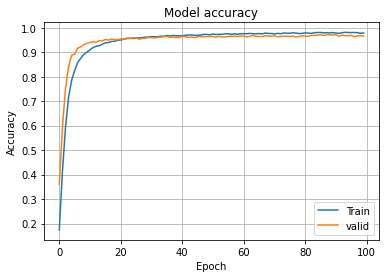

In [0]:
plt.plot(train_model_dropOut.history['accuracy'])
plt.plot(train_model_dropOut.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'valid'], loc='lower right')
plt.grid()
plt.show()

## Data Agumentation using keras: [link here](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)

In [0]:
tr_images , tr_labels = readTrafficSigns('./GTSRB/Training')
ts_images , ts_labels = TSreadTrafficSigns('./GTSRB/Final_Test/Images/')

# make all the images have size(30, 30)
for i , img in enumerate(tr_images):
    tr_images[i] = cv2.resize(img , (30,30))

for i, img in enumerate(ts_images):
    ts_images[i] = cv2.resize(img, (30,30))

tr_images  = np.array(tr_images , dtype='float32')
ts_images  = np.array(ts_images , dtype='float32')
tr_labels = keras.utils.to_categorical(tr_labels)
ts_labels = keras.utils.to_categorical(ts_labels)

In [0]:
datagen = IDG(featurewise_center=True,
              featurewise_std_normalization=True,
              rotation_range=20,
              width_shift_range=0.2,
              height_shift_range=0.2,
              horizontal_flip=True,
              shear_range=0.2,
              zoom_range=0.2,
              brightness_range =[0.1, 1])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


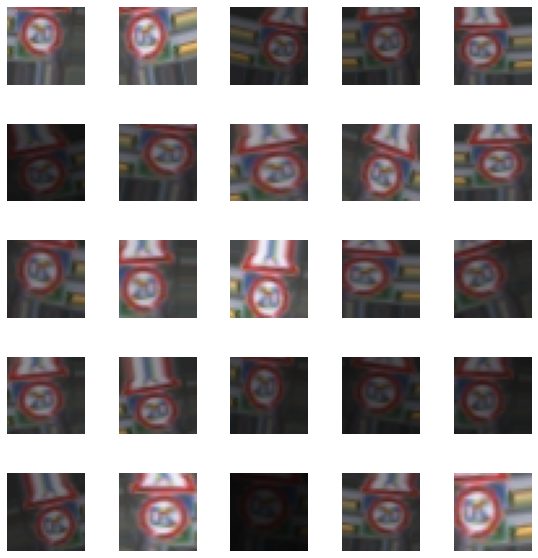

In [0]:
it = datagen.flow(np.array(tr_images[0:1]), batch_size=1)
fig, axs = plt.subplots(5,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(25):
    image = next(it)[0].astype('uint8')
    axs[i].axis('off')
    axs[i].imshow(image)

In [0]:
datagen.fit(tr_images)

In [0]:
model_augmented = create_drop_out_model()
model_augmented.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_no_augmented = create_drop_out_model()
model_no_augmented.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
agumented_history = model_augmented.fit_generator(datagen.flow(tr_images, tr_labels, batch_size=128),
                                    steps_per_epoch=len(tr_labels)/128, epochs=100,
                                    validation_data=(ts_images, ts_labels) )

Epoch 1/100
209/208 [==============================] - 26s 122ms/step - loss: 3.3816 - accuracy: 0.0939 - val_loss: 13.1083 - val_accuracy: 0.2079
Epoch 2/100
209/208 [==============================] - 25s 119ms/step - loss: 2.7140 - accuracy: 0.2234 - val_loss: 17.9257 - val_accuracy: 0.3890
Epoch 3/100
209/208 [==============================] - 25s 120ms/step - loss: 2.2143 - accuracy: 0.3254 - val_loss: 15.6478 - val_accuracy: 0.4803
Epoch 4/100
209/208 [==============================] - 25s 119ms/step - loss: 1.8890 - accuracy: 0.3934 - val_loss: 15.2470 - val_accuracy: 0.5041
Epoch 5/100
209/208 [==============================] - 25s 119ms/step - loss: 1.7327 - accuracy: 0.4347 - val_loss: 13.5699 - val_accuracy: 0.5441
Epoch 6/100
209/208 [==============================] - 25s 120ms/step - loss: 1.5988 - accuracy: 0.4771 - val_loss: 15.1331 - val_accuracy: 0.5821
Epoch 7/100
209/208 [==============================] - 25s 119ms/step - loss: 1.4775 - accuracy: 0.5102 - val_loss: 12

In [0]:
no_agumented_history = model_no_augmented.fit(tr_images, tr_labels,
                       validation_data=(ts_images, ts_labels), batch_size=128, epochs = 100)

Train on 26640 samples, validate on 12630 samples
Epoch 1/100
26640/26640 [==============================] - 4s 140us/step - loss: 5.8427 - accuracy: 0.0518 - val_loss: 3.5591 - val_accuracy: 0.0747
Epoch 2/100
26640/26640 [==============================] - 3s 118us/step - loss: 3.4042 - accuracy: 0.0964 - val_loss: 3.1435 - val_accuracy: 0.2100
Epoch 3/100
26640/26640 [==============================] - 3s 118us/step - loss: 3.0269 - accuracy: 0.1851 - val_loss: 2.6003 - val_accuracy: 0.3013
Epoch 4/100
26640/26640 [==============================] - 3s 118us/step - loss: 2.6501 - accuracy: 0.2547 - val_loss: 2.2833 - val_accuracy: 0.3545
Epoch 5/100
26640/26640 [==============================] - 3s 117us/step - loss: 2.4313 - accuracy: 0.3012 - val_loss: 2.0125 - val_accuracy: 0.4010
Epoch 6/100
26640/26640 [==============================] - 3s 119us/step - loss: 2.2256 - accuracy: 0.3345 - val_loss: 1.9376 - val_accuracy: 0.3966
Epoch 7/100
26640/26640 [==============================]

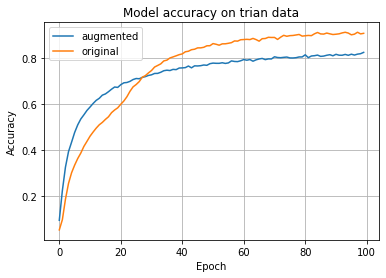

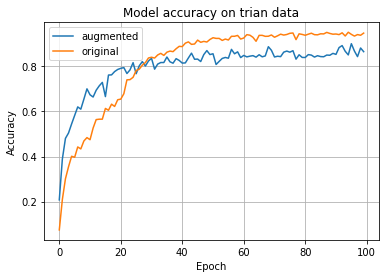

In [0]:
plt.plot(agumented_history.history['accuracy'])
plt.plot(no_agumented_history.history['accuracy'])
plt.title('Model accuracy on trian data')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['augmented', 'original'], loc='upper left')
plt.grid()
plt.show()

plt.plot(agumented_history.history['val_accuracy'])
plt.plot(no_agumented_history.history['val_accuracy'])
plt.title('Model accuracy on trian data')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['augmented', 'original'], loc='upper left')
plt.grid()
plt.show()

## batch normalization

In [0]:
def create_batch_norm_model(n_classes = 43):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),activation= 'relu' , input_shape=(30, 30, 3))) # 28x28x32
  model.add(MaxPooling2D(pool_size=(2, 2))) # 14x14x32
  model.add(BatchNormalization())

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) # 12x12x64
  model.add(MaxPooling2D(pool_size=(2, 2))) # 6x6x64
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) #4x4x128
  model.add(MaxPooling2D(pool_size=(2, 2))) #2x2x128
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))
  return model

In [0]:
model_batched = create_batch_norm_model()
model_no_batch = create_drop_out_model()
model_batched.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_no_batch.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
batched_history = model_batched.fit(tr_images, tr_labels, validation_data=(ts_images, ts_labels), batch_size=128, epochs = 30)

Train on 26640 samples, validate on 12630 samples
Epoch 1/30
26640/26640 [==============================] - 5s 198us/step - loss: 3.1336 - accuracy: 0.1946 - val_loss: 1.9946 - val_accuracy: 0.4165
Epoch 2/30
26640/26640 [==============================] - 4s 163us/step - loss: 1.8080 - accuracy: 0.4526 - val_loss: 1.5143 - val_accuracy: 0.5444
Epoch 3/30
26640/26640 [==============================] - 4s 164us/step - loss: 1.1430 - accuracy: 0.6310 - val_loss: 0.9066 - val_accuracy: 0.7096
Epoch 4/30
26640/26640 [==============================] - 4s 165us/step - loss: 0.7873 - accuracy: 0.7440 - val_loss: 0.4888 - val_accuracy: 0.8606
Epoch 5/30
26640/26640 [==============================] - 4s 165us/step - loss: 0.5964 - accuracy: 0.8078 - val_loss: 0.3708 - val_accuracy: 0.8911
Epoch 6/30
26640/26640 [==============================] - 4s 165us/step - loss: 0.4772 - accuracy: 0.8461 - val_loss: 0.3309 - val_accuracy: 0.9061
Epoch 7/30
26640/26640 [==============================] - 4s 1

In [0]:
no_batche_history = model_no_batch.fit(tr_images, tr_labels, validation_data=(ts_images, ts_labels), batch_size=128, epochs = 30)

Train on 26640 samples, validate on 12630 samples
Epoch 1/30
26640/26640 [==============================] - 3s 131us/step - loss: 5.0623 - accuracy: 0.0581 - val_loss: 3.4242 - val_accuracy: 0.1522
Epoch 2/30
26640/26640 [==============================] - 3s 120us/step - loss: 3.2523 - accuracy: 0.1405 - val_loss: 2.8388 - val_accuracy: 0.2287
Epoch 3/30
26640/26640 [==============================] - 3s 116us/step - loss: 2.8963 - accuracy: 0.2072 - val_loss: 2.5650 - val_accuracy: 0.3041
Epoch 4/30
26640/26640 [==============================] - 3s 118us/step - loss: 2.6006 - accuracy: 0.2610 - val_loss: 2.4194 - val_accuracy: 0.3303
Epoch 5/30
26640/26640 [==============================] - 3s 119us/step - loss: 2.3680 - accuracy: 0.2919 - val_loss: 2.0811 - val_accuracy: 0.3657
Epoch 6/30
26640/26640 [==============================] - 3s 117us/step - loss: 2.2228 - accuracy: 0.3159 - val_loss: 1.9129 - val_accuracy: 0.3948
Epoch 7/30
26640/26640 [==============================] - 3s 1

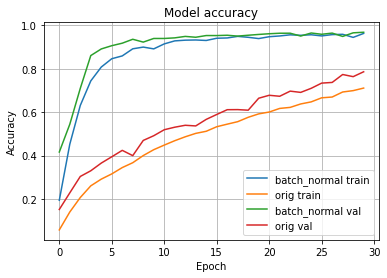

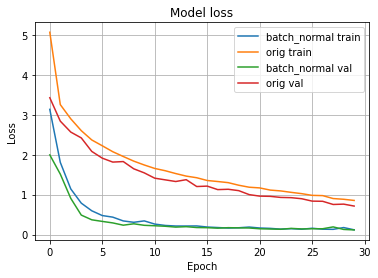

In [0]:
plt.plot(batched_history.history['accuracy'])
plt.plot(no_batche_history.history['accuracy'])
plt.plot(batched_history.history['val_accuracy'])
plt.plot(no_batche_history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['batch_normal train', 'orig train', 'batch_normal val', 'orig val'])
plt.grid()
plt.show()

plt.plot(batched_history.history['loss'])
plt.plot(no_batche_history.history['loss'])
plt.plot(batched_history.history['val_loss'])
plt.plot(no_batche_history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['batch_normal train', 'orig train', 'batch_normal val', 'orig val'], loc='upper right')
plt.grid()
plt.show()

